<a href="https://colab.research.google.com/github/AliJaffery12/Step_Length_Estimation_Using_LSTM_Model_DeepLearning/blob/main/StepPrediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TASK : Step Detection
-
To predict the start and end of human steps from a set of 6 signals. The data was recorded using accelerometer and gyroscope sensors, which were held in hand during 4 different activities, including simple walking, walking up and down stairs, and standing still.


In [ ]:
# imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Load Data

"Loading Training Data: Concatenating Signal Data and Step Labels"

In this section, we define a function called load_training_data to load the training data from the specified data folder.

In [ ]:
def load_training_data(data_folder):
    # Retrieve the folders within the data folder
    folders = [folder for folder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, folder))]

    # Sort the folders based on the numeric part of their names
    folders = [folder for folder in folders if any(char.isdigit() for char in folder)]
    folders.sort(key=lambda file: int(file.lower().split('_')[1]))

    signal_data = []
    step_labels = []

    signal_files_set = set()
    step_label_files_set = set()

    for folder in folders:
        # Get the file path for the current folder
        file_path = os.path.join(data_folder, folder)

        # Retrieve the signal and step label files within the folder
        signal_files = [file for file in os.listdir(file_path) if file.endswith('.csv')]
        step_label_files = [file for file in os.listdir(file_path) if file.endswith('.csv.stepMixed')]

        # Check if both signal and step label files exist
        if len(signal_files) != len(step_label_files):
            raise ValueError(f"Incomplete data in folder: {folder}. Missing signal or step label files.")

        # Sort the file lists to ensure consistent pairing
        signal_files.sort()
        step_label_files.sort()

        for signal_file, step_label_file in zip(signal_files, step_label_files):
            signal_file_path = os.path.join(file_path, signal_file)
            step_label_file_path = os.path.join(file_path, step_label_file)

            # Check for duplicated signal and step label files
            if signal_file in signal_files_set:
                raise ValueError(f"Duplicated signal file found: {signal_file}.")
            if step_label_file in step_label_files_set:
                raise ValueError(f"Duplicated step label file found: {step_label_file}.")

            signal_files_set.add(signal_file)
            step_label_files_set.add(step_label_file)

            # Read the signal and step label files into pandas dataframes
            signal_data.append(pd.read_csv(signal_file_path))
            step_labels.append(pd.read_csv(step_label_file_path, header=None, names=['start', 'end']))

    # Check if any files were found and loaded
    if len(signal_data) == 0 or len(step_labels) == 0:
        raise ValueError("No signal or step label files found in the data folder.")

    # Concatenate the loaded signal data and step labels
    signal_data = pd.concat(signal_data)
    step_labels = pd.concat(step_labels)

    return signal_data, step_labels

In [ ]:
# Specify the path to the training data folder
data_folder = '/content/data'

# Load the training data
signal_data, step_labels = load_training_data(data_folder)

Using head() function to preview of the data to understand the structure and content of the dataframe. It returns the first 5 rows of the dataframe.

In [ ]:
# Retrieving the first 5 rows of the signal_data dataframe
signal_data.head()

,Activity,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5
0,0,0.148915,4.705827,8.557376,-0.013430,-0.001028,0.017995
1,0,0.202848,4.666829,8.485154,-0.027897,-0.000346,0.016360
2,0,0.232652,4.668847,8.412815,-0.038700,0.023742,0.001388
3,0,0.194148,4.665260,8.463220,-0.049840,0.054852,-0.014097
4,0,0.118559,4.698190,8.585538,-0.061949,0.075178,-0.022977


In [ ]:
# Retrieve the first 5 rows of the step_labels dataframe
step_labels.head()

,start,end
0,557,606
1,650,690
2,731,767
3,797,819
4,842,861


The mean() function calculates the average value for each column of the dataframe. Here,
"signal_data_mean" contains the mean values for each column, providing an insight into the central tendency of the data.
It helps in understanding the average values of the accelerometer and gyroscope measurements.


In [ ]:
# Calculate the mean of the signal_data dataframe
signal_data.mean()

 Activity    1.021754
 AccelX_5   -0.246649
 AccelY_5    3.377784
 AccelZ_5    7.931571
 GyroX_5     0.000584
 GyroY_5     0.006406
 GyroZ_5     0.011035
dtype: float64

## 2. Pre-process Data

#### 2.1 "Checking for Missing Values in Signal Data and Step Labels"

In this section, we verify the presence of any missing values in the signal data and step labels. This is important to ensure data quality and identify if there are any gaps in the datasets. By performing this check, we can determine if any further steps are needed to handle missing values and make informed decisions during the data analysis process.

In [ ]:
# Check for missing values in signal_data
print("Missing values in signal_data:")
print(signal_data.isnull().sum())

# Check for missing values in step_labels
print("\nMissing values in step_labels:")
print(step_labels.isnull().sum())

Missing values in signal_data:
 Activity    0
 AccelX_5    0
 AccelY_5    0
 AccelZ_5    0
 GyroX_5     0
 GyroY_5     0
 GyroZ_5     0
dtype: int64

Missing values in step_labels:
start    0
end      0
dtype: int64


#### 2.2 "Removing Leading Spaces, Dropping Activity Column, and Extracting Accelerometer and Gyroscope Data"

In this section, we perform preprocessing steps on the signal data to ensure data cleanliness and extract specific data components.

In [ ]:
# Remove leading spaces from column names
signal_data.columns = signal_data.columns.str.strip()

# Drop the first column (activity column)
signal_data = signal_data.drop(columns=['Activity'])

# Verify the number of columns in signal_data
signal_columns = signal_data.shape[1]
print("Number of signal data columns:", signal_columns)
print("Columns of signal data: ", signal_data.columns)

# Select the columns for accelerometers and gyroscopes
accel_columns = ['AccelX_5', 'AccelY_5', 'AccelZ_5']
gyro_columns = ['GyroX_5', 'GyroY_5', 'GyroZ_5']

# Extract accelerometer and gyroscope data
accel_data = signal_data[accel_columns].values
gyro_data = signal_data[gyro_columns].values

Number of signal data columns: 6
Columns of signal data:  Index(['AccelX_5', 'AccelY_5', 'AccelZ_5', 'GyroX_5', 'GyroY_5', 'GyroZ_5'], dtype='object')


#### 2.3 "Creating Target Labels"

In this section, the code defines a function called create_target_labels to generate target labels for the steps based on the provided step labels and signal length.

In [ ]:
def create_target_labels(step_labels, signal_length):
    """
    Create target labels for the steps based on the provided step labels and signal length.

    Args:
    - step_labels (pd.DataFrame): Dataframe containing step labels with 'start' and 'end' columns.
    - signal_length (int): Length of the signal.

    Returns:
    - target_labels (np.ndarray): Array representing the target labels for the steps.
    """

    # Initialize the target labels array with zeros
    target_labels = np.zeros((signal_length, 2))

    # Iterate over each step label
    for _, step_label in step_labels.iterrows():
        # Extract the 'start' and 'end' columns respectively.
        start = step_label['start']
        end = step_label['end']

        # Set the corresponding indices in the target_labels array to 1
        target_labels[start, 0] = 1
        target_labels[end, 1] = 1

    return target_labels


In [ ]:
# Compute signal length and create target labels
signal_length = len(signal_data)
target_labels = create_target_labels(step_labels, signal_length)

print("Length of the signal data :", signal_length)

# Convert target_labels to a DataFrame with column names
target_labels = pd.DataFrame(target_labels, columns=['Start', 'End'])

print("Number of target label columns:", target_labels.shape[1])
print("Columns of target label: ", target_labels.columns)

Length of the signal data : 722582
Number of target label columns: 2
Columns of target label:  Index(['Start', 'End'], dtype='object')


#### 2.4 Normalisation

In this section, the code performs normalization on the accelerometer and gyroscope data. The purpose of normalization is to scale the data to a consistent range, which can help improve the performance and convergence of the models.

The normalization process is done using two techniques: min-max normalization and z-score normalization.

- Min-Max normalization, also known as feature scaling, is a data preprocessing technique that transforms the values of numerical features to a fixed range, typically between 0 and 1. The purpose of Min-Max normalization is to bring all features to a similar scale, ensuring that they have comparable magnitudes.

In [ ]:
def normalize_data_min_max(data):
    """
    Perform Min-Max normalization on the input data.

    Args:
    - data (np.ndarray): Input data to be normalized.

    Returns:
    - normalized_data (np.ndarray): Min-Max normalized data.
    """
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

- Z-score normalization, also known as standardization, is a data preprocessing technique that transforms the values of numerical features to have zero mean and unit standard deviation. This technique rescales the data to a standard normal distribution, making it easier to compare and analyze the features.

In [ ]:
def normalize_data_z_score(data):
    """
    Perform Z-score normalization on the input data.

    Args:
    - data (np.ndarray): Input data to be normalized.

    Returns:
    - normalized_data (np.ndarray): Z-score normalized data.
    """

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    return normalized_data

In [ ]:
# Normalize accelerometer and gyroscope data using min-max normalization
normalized_accelerometer_data_min_max = normalize_data_min_max(accel_data)
normalized_gyroscope_data_min_max = normalize_data_min_max(gyro_data)

# Normalize accelerometer and gyroscope data using z-score normalization
normalized_accelerometer_data_z_score = normalize_data_z_score(accel_data)
normalized_gyroscope_data_z_score = normalize_data_z_score(gyro_data)

- DataFrame to compare the means of the original accelerometer and gyroscope data with the means of the corresponding normalized data using min-max normalization and z-score normalization techniques.This table allows for a quick comparison of the means across different data types and helps understand the impact of normalization on the data.

In [ ]:
# Create a DataFrame with the data
data = {
    'Data Type': ['Original Data', 'Min-Max Normalized Data', 'Z-Score Normalized Data'],
    'Accelerometer Data': [accel_data.mean(), normalized_accelerometer_data_min_max.mean(), normalized_accelerometer_data_z_score.mean()],
    'Gyroscope Data': [gyro_data.mean(), normalized_gyroscope_data_min_max.mean(), normalized_gyroscope_data_z_score.mean()]
}

df = pd.DataFrame(data)

# Display the DataFrame
display(df)

,Data Type,Accelerometer Data,Gyroscope Data
0,Original Data,3.687569e+00,6.008288e-03
1,Min-Max Normalized Data,4.699532e-01,4.969475e-01
2,Z-Score Normalized Data,-2.284492e-16,-7.342261e-19


- The signal data is updated with the z-score normalized data.

In [ ]:
# Update the signal data with z_score normalized dat
signal_data[accel_columns] = normalized_accelerometer_data_z_score
signal_data[gyro_columns] = normalized_gyroscope_data_z_score

# Verify the normalized signal data
print(signal_data.head())

   AccelX_5  AccelY_5  AccelZ_5   GyroX_5   GyroY_5   GyroZ_5
0  0.205640  0.550940  0.144466 -0.032237 -0.017374  0.011598
1  0.233678  0.534761  0.127794 -0.065515 -0.015780  0.008873
2  0.249172  0.535598  0.111095 -0.090364  0.040519 -0.016074
3  0.229155  0.534110  0.122730 -0.115989  0.113229 -0.041877
4  0.189859  0.547771  0.150967 -0.143843  0.160735 -0.056674


## 3. Visualisation

In this section, we will perform various visualizations to gain insights into the data. Visualizations can help us understand the distribution of features, relationships between variables, and patterns in the data.

-  Plot histograms for different columns of signal_data DataFrame, providing a visual representation of the distribution of data within each column.

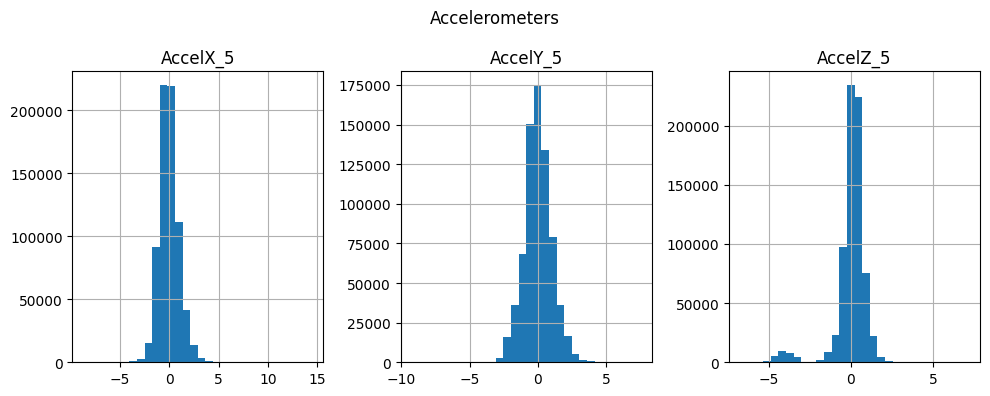

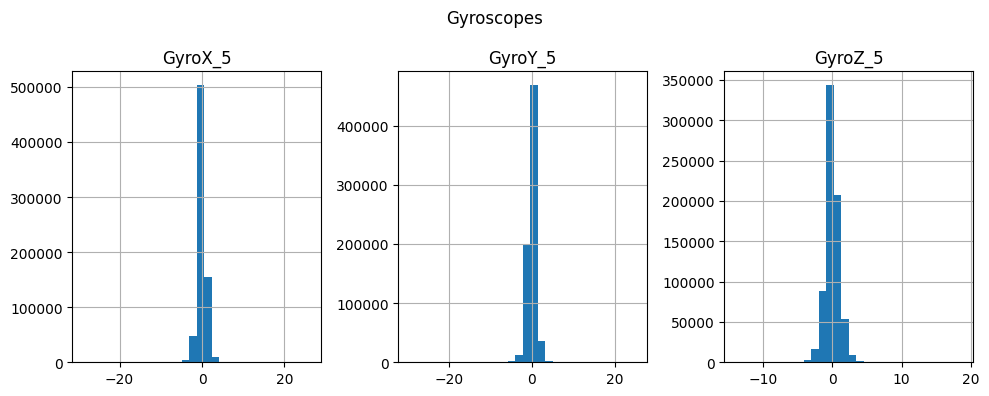

In [ ]:
def plot_histograms(data, columns, title, bins=20):
    """
    Plot histograms for the specified columns of the given data.

    Args:
        data (pd.DataFrame): Input data containing the columns to plot histograms.
        columns (list): List of column names to plot histograms for.
        title (str): Title for the row of subplots.
        bins (int): Number of bins for the histograms. Default is 20.

    Returns:
        None
    """

    # Create subplots with 1 row and 3 columns
    fig, axs = plt.subplots(1, len(columns), figsize=(10, 4))

    # Plot histograms for each column
    for i, col in enumerate(columns):
        ax = axs[i]
        data[col].hist(bins=bins, ax=ax)
        ax.set_title(col)

    fig.suptitle(title) # Set the common title for the row
    fig.tight_layout() # Adjust the spacing between subplots
    plt.show()  # Show the plot

# Plot histograms for accelerometers
plot_histograms(signal_data, accel_columns, 'Accelerometers', bins=30)

# Plot histograms for gyroscopes
plot_histograms(signal_data, gyro_columns, 'Gyroscopes', bins=30)

-  Plot histograms for different columns of step_labels and target_labels DataFrame, providing a visual representation of the distribution of data within each column.

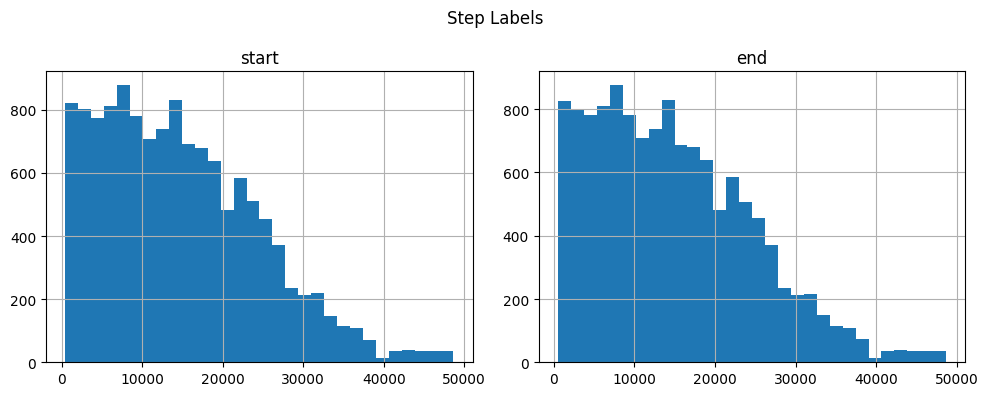

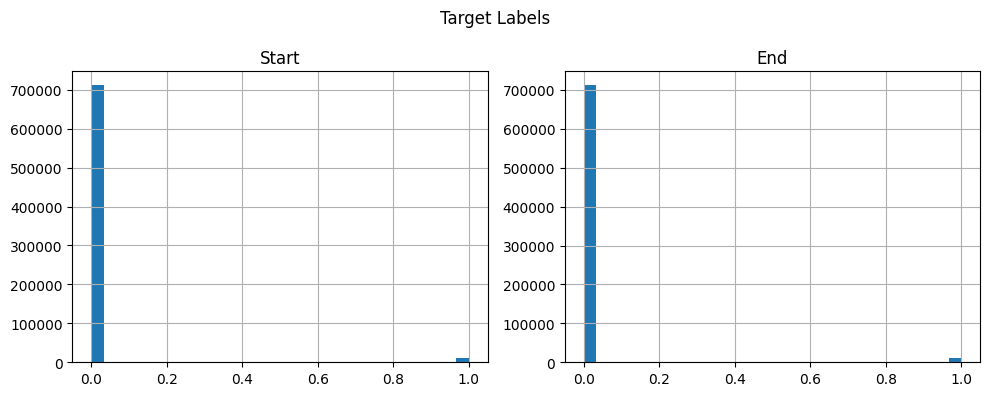

In [ ]:
step_labels_col = step_labels.columns
target_labels_col = target_labels.columns

plot_histograms(step_labels, step_labels_col, 'Step Labels', bins=30)
plot_histograms(target_labels, target_labels_col, 'Target Labels', bins=30)


- To explore the relationships between different variables in the signal data, we can create a correlation matrix. The correlation matrix measures the linear relationship between pairs of variables.

Here, the correlation matrix and heatmap provide insights into the relationships between the different columns of the signal_data DataFrame. Positive correlations are represented by warmer colors, while negative correlations are represented by cooler colors. The intensity of the colors indicates the strength of the correlation. This analysis helps to identify potential patterns, dependencies, or redundancies in the data.

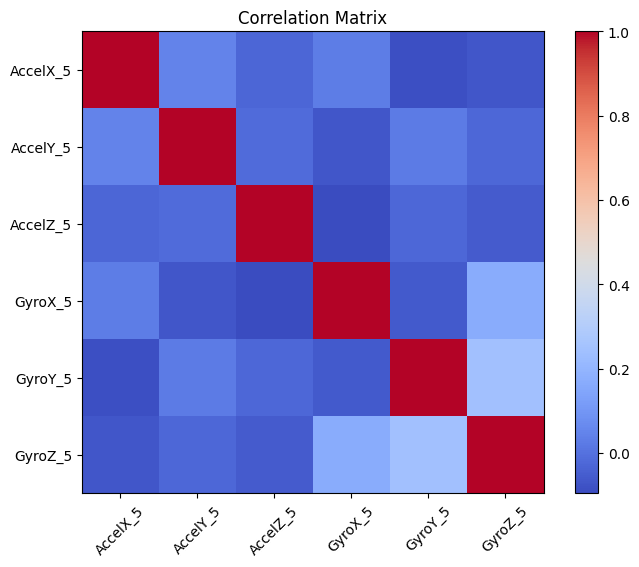

In [ ]:
def plot_correlation_matrix(data):
    """
    Plot the correlation matrix of the input data using a heatmap.

    Args:
        data (pd.DataFrame): Input data to compute the correlation matrix.

    Returns:
        None
    """
    correlation_matrix = data.corr()

    plt.figure(figsize=(8, 6))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.title("Correlation Matrix")
    plt.xticks(range(correlation_matrix.shape[1]), correlation_matrix.columns, rotation=45)
    plt.yticks(range(correlation_matrix.shape[1]), correlation_matrix.columns)
    plt.colorbar()
    plt.show()

# plot correlation matrix using heatmap for signal data
plot_correlation_matrix(signal_data)

- The scatter plot is a visual representation of the relationship between two variables.

Here, the scatter plot is created to visualize the relationship between the normalized accelerometer data (X-axis) and normalized gyroscope data (X-axis). By examining the scatter plot, one can observe the distribution and pattern of the data points, which can provide insights into the relationship between the accelerometer and gyroscope measurements.

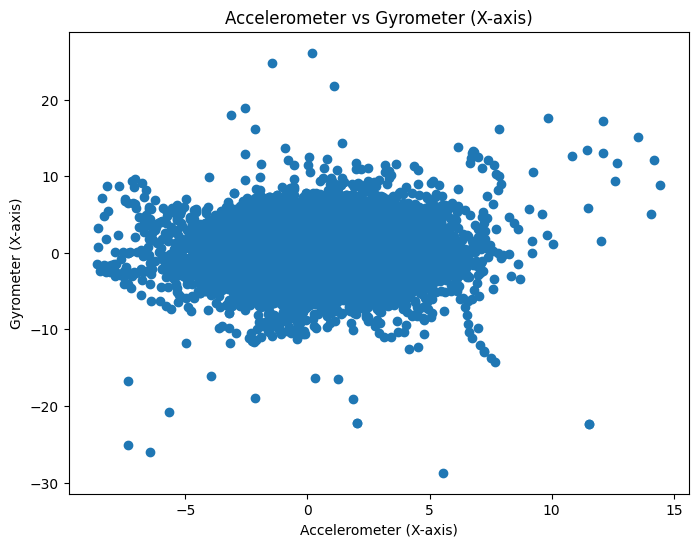

In [ ]:
def plot_scatter(x, y, title, x_label, y_label):
    """
    Plot a scatter plot of the given x and y data.

    Args:
        x (np.array): Input x data.
        y (np.array): Input y data.
        title (str): Title of the scatter plot.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

# Plot scatter plot for accelerometer vs gyroscope (X-axis)
plot_scatter(normalized_accelerometer_data_z_score[:, 0], normalized_gyroscope_data_z_score[:, 0],
             "Accelerometer vs Gyrometer (X-axis)", "Accelerometer (X-axis)", "Gyrometer (X-axis)")


## 4. Create Datasets and Dataloaders

In this section, the process of creating datasets and data loaders is highlighted for essential steps in preparing data for given task.

- The SignalDataset class is created to provide a custom dataset for input signals and their corresponding target labels. This custom dataset class is useful for organizing and accessing the input signals and target labels in a convenient way for further processing, such as creating data loaders for training and validation.

In [ ]:
class SignalDataset(Dataset):
    def __init__(self, signals, targets):
        """
        Initialize the SignalDataset class.

        Args:
        - signals (numpy.ndarray): Array of input signals.
        - targets (numpy.ndarray): Array of corresponding target labels.
        """
        self.signals = signals
        self.targets = targets

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.signals)

    def __getitem__(self, index):
        """
        Retrieve a specific sample from the dataset given its index.

        Args:
        - index (int): Index of the sample to retrieve.

        Returns:
        - signal (numpy.ndarray): Input signal of the sample.
        - target (numpy.ndarray): Corresponding target label of the sample.
        """
        signal = self.signals[index]
        target = self.targets[index]
        return signal, target

- The 'create_datasets' is used to create training and validation datasets for given task. It takes in the input signal data and corresponding target labels, as well as parameters such as window size and stride.

    1. The function creates sliding windows from the input signal data and target labels. It slides a window of a specified size over the data with a given stride, extracting the corresponding window of signal data and target labels at each position. These windows are stored in separate lists.
    2. If the number of folds for k-fold cross-validation is specified, the function divides the windows into the specified number of folds. It creates validation and training sets for each fold by extracting the corresponding windows.
    3. If the train ratio for a direct split is specified, the function splits the windows into training and validation sets based on the specified ratio.

In [ ]:
def create_datasets(signal_data, target_labels, window_size, stride, num_folds=None, train_ratio=None):
    """
    Create datasets for training and validation.

    Args:
    - signal_data (numpy.ndarray): Array of input signal data.
    - target_labels (numpy.ndarray): Array of corresponding target labels.
    - window_size (int): Size of the sliding window.
    - stride (int): Stride value for creating windows.
    - num_folds (int): Number of folds for k-fold cross-validation. Set to None for direct split.
    - train_ratio (float): Ratio of training data to total data. Set to None for k-fold cross-validation.

    Returns:
    - datasets (list): List of tuples, each containing a training dataset and a validation dataset.
      If num_folds is None, the list will contain a single tuple.

    Raises:
    - ValueError: If both num_folds and train_ratio are provided or if neither is provided.
    """

    # Check if only one of num_folds or train_ratio is provided
    if (num_folds is not None and train_ratio is not None) or (num_folds is None and train_ratio is None):
        raise ValueError("Either num_folds or train_ratio should be provided, but not both or neither.")

    # Check if signal data and target labels have the same length
    if len(signal_data) != len(target_labels):
        raise ValueError("Signal data and target labels must have the same length.")

    signal_windows = []
    target_windows = []

    # Create sliding windows of signal data and target labels
    for i in range(0, len(signal_data) - window_size + 1, stride):
        signal_window = signal_data[i:i+window_size] # Extract the current signal window
        target_window = target_labels[i:i+window_size] # Extract the corresponding target window

        signal_windows.append(signal_window) # Append the signal window to the list of signal windows
        target_windows.append(target_window) # Append the target window to the list of target windows

    # Convert the lists of signal windows and target windows to numpy arrays
    signal_windows = np.array(signal_windows)
    target_windows = np.array(target_windows)

    # Convert the numpy arrays to torch tensors for further processing
    signal_windows = torch.tensor(signal_windows, dtype=torch.float32)
    target_windows = torch.tensor(target_windows, dtype=torch.float32)

    # Check if the number of folds is specified
    if num_folds is not None:

        fold_size = len(signal_windows) // num_folds # Calculate the size of each fold
        datasets = []  # Initialize an empty list to store the datasets for each fold

        for fold in range(num_folds): # Iterate over each fold
            # Calculate the start and end indices for the current fold
            start = fold * fold_size
            end = (fold + 1) * fold_size

            # Split the data into validation and training sets for the current fold
            X_val = signal_windows[start:end]
            y_val = target_windows[start:end]
            X_train = torch.cat((signal_windows[:start], signal_windows[end:]), dim=0)
            y_train = torch.cat((target_windows[:start], target_windows[end:]), dim=0)

            # Create SignalDataset objects for the training and validation sets
            train_dataset = SignalDataset(X_train, y_train)
            val_dataset = SignalDataset(X_val, y_val)

             # Append the training and validation datasets to the list of datasets
            datasets.append((train_dataset, val_dataset))

        # Return the list of datasets for each fold
        return datasets

    # Check if the train_ratio is specified
    if train_ratio is not None:
        # Calculate the size of the training set based on the train_ratio
        train_size = int(train_ratio * len(signal_windows))
        # Calculate the size of the validation set
        val_size = len(signal_windows) - train_size

        # Split the data into training and validation sets based on the sizes
        X_train = signal_windows[:train_size]
        y_train = target_windows[:train_size]
        X_val = signal_windows[train_size:]
        y_val = target_windows[train_size:]

        # Create SignalDataset objects for the training and validation sets
        train_dataset = SignalDataset(X_train, y_train)
        val_dataset = SignalDataset(X_val, y_val)

        # Return a list containing the training and validation datasets
        return  [(train_dataset, val_dataset)]

In [ ]:
# Specify the parameters
window_size = 50
stride = window_size // 2
num_folds = 5
train_ratio = 0.8

# Call the function to create datasets
datasets = create_datasets(signal_data, target_labels, window_size, stride, num_folds, train_ratio=None)

- The batch loaders are used to iterate over the data in batches during training and evaluation processes, enabling efficient processing of large datasets.

In [ ]:
# Create the batch loaders
batch_size = 30

# Extract the training and validation datasets from the list of tuples
for train_dataset, val_dataset in datasets:
    # Use train_dataset and val_dataset for each fold or direct split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check the shape of the input data from the train_loader
input_shape = next(iter(train_loader))[0].shape
print("Input shape:", input_shape)

# Inspect a single batch for train loader
for batch_data, labels in train_loader:
    batch_data = batch_data  # Extract the first element from the batch
    labels = labels # Extract the first element from the batch
    start_labels = labels[:, :, 0]  # Extract the start labels from the third dimension
    end_labels = labels[:, :, 1]  # Extract the end labels from the third dimension

    print("\nTrain Batch Data Shape:", batch_data.shape)
    print("Train Labels Shape:", labels.shape)
    print("Train Start Labels Shape:", start_labels.shape)
    print("Train End Labels Shape:", end_labels.shape)

    break

# Inspect a single batch for val loader
for batch_data, labels in val_loader:
    batch_data = batch_data  # Extract the first element from the batch
    labels = labels # Extract the first element from the batch
    start_labels = labels[:, :, 0]  # Extract the start labels from the third dimension
    end_labels = labels[:, :, 1]  # Extract the end labels from the third dimension

    print("\nTest Batch Data Shape:", batch_data.shape)
    print("Test Labels Shape:", labels.shape)
    print("Test Start Labels Shape:", start_labels.shape)
    print("Test End Labels Shape:", end_labels.shape)

    break

Input shape: torch.Size([30, 50, 6])

Train Batch Data Shape: torch.Size([30, 50, 6])
Train Labels Shape: torch.Size([30, 50, 2])
Train Start Labels Shape: torch.Size([30, 50])
Train End Labels Shape: torch.Size([30, 50])

Test Batch Data Shape: torch.Size([30, 50, 6])
Test Labels Shape: torch.Size([30, 50, 2])
Test Start Labels Shape: torch.Size([30, 50])
Test End Labels Shape: torch.Size([30, 50])


## 5. Define Models

- Long Short Term Memory (LSTM) allows for the processing of sequential input data, capturing temporal dependencies using the LSTM layer, and mapping the hidden state to the desired output size through fully connected layers.

    - Dropout is used, which is a regularization technique to prevent overfitting and improve generalization performance.
    - ReLU (Rectified Linear Unit) is an activation function which introduces non-linearity to the network and helps the model learn complex patterns in the data.
    - Sigmoid is an activation function used to predict probabilities for the output layer of the model. The sigmoid function maps the logits or raw scores to a range between 0 and 1, which can be interpreted as probabilities. Each output dimension (start and end) will have a sigmoid activation applied, giving the probability values for each time point.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(dropout_rate)

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, output_size),
            nn.Sigmoid()  # Sigmoid activation function
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc_layers(out)  # Pass through the Fully connected layers

        return out

# Define the hyperparameters
input_size = signal_data.shape[1] # number of columns of signal data
hidden_size = 128
num_layers = 2
dropout_rate = 0.5
output_size = target_labels.shape[1] # number of columns of target labels

# Initialize the model
lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate).to(device)
print(lstm_model)

LSTMModel(
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
    (4): Sigmoid()
  )
)


## 6. Train Models

- In this section, there are function for evaluation metrics. The functions assumes that the predictions and targets are binary tensors (containing only 0s and 1s). The functions use the rounded predictions (values rounded to the nearest integer) for comparison and calculation. Division by zero is handled to avoid any runtime errors.

1. The calculate_accuracy function takes the predicted values and true labels, compares them, and computes the accuracy by dividing the number of correct predictions by the total number of predictions. It provides a convenient way to evaluate the accuracy of the model's predictions in a binary classification scenario.

2. Precision is a metric that measures the proportion of correctly predicted positive instances (true positives) out of all instances predicted as positive. It is computed by dividing the number of true positives by the total number of instances predicted as positive.

3. Recall, also known as sensitivity or true positive rate, is a metric that measures the proportion of correctly predicted positive instances (true positives) out of all actual positive instances. It is computed by dividing the number of true positives by the total number of actual positive instances.

4. The F1 score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. The F1 score is computed by taking the weighted average of precision and recall, where precision and recall have equal importance. It is commonly used as a measure of a model's accuracy in binary classification tasks.

In [ ]:
def calculate_accuracy(predictions, labels):
    """
    Calculates the accuracy of model predictions.

    Parameters:
        predictions (torch.Tensor): A tensor representing the predicted values from the model.
        labels (torch.Tensor): A tensor containing the true labels corresponding to the predictions.

    Returns:
        float: The accuracy of the predictions as a value between 0 and 1.

    """
    rounded_predictions = torch.round(predictions)
    correct = (rounded_predictions == labels).sum().item()
    total = labels.numel()
    accuracy = correct / total
    return accuracy

def calculate_precision(predictions, targets):
    """
    Calculates the precision score for binary classification predictions.

    Parameters:
        predictions (torch.Tensor): A tensor containing the predicted values.
        targets (torch.Tensor): A tensor containing the true target values.
    Returns:
        precision (float): The precision score.
    """
    rounded_predictions = torch.round(predictions)
    true_positives = ((rounded_predictions == 1) & (targets == 1)).sum().item()
    predicted_positives = (rounded_predictions == 1).sum().item()

    # Handle division by zero when predicted_positives is zero
    if predicted_positives == 0:
        precision = 0.0
    else:
        precision = true_positives / predicted_positives

    return precision


def calculate_recall(predictions, targets):
    """
    Calculates the recall score for binary classification predictions.

    Parameters:
        predictions (torch.Tensor): A tensor containing the predicted values.
        targets (torch.Tensor): A tensor containing the true target values.
    Returns:
        recall (float): The recall score.
    """
    rounded_predictions = torch.round(predictions)
    true_positives = ((rounded_predictions == 1) & (targets == 1)).sum().item()
    actual_positives = (targets == 1).sum().item()

    # Handle division by zero when actual positives count is zero
    if actual_positives == 0:
        recall = 0.0
    else:
        recall = true_positives / actual_positives

    return recall

def calculate_f1_score(predictions, targets):
    """
    Calculates the F1 score for binary classification predictions.

    Parameters:
        predictions (torch.Tensor): A tensor containing the predicted values.
        targets (torch.Tensor): A tensor containing the true target values.
    Returns:
    f1_score (float): The F1 score.
    """
    precision = calculate_precision(predictions, targets)
    recall = calculate_recall(predictions, targets)

    # Handle division by zero when both precision and recall are zero
    if precision == 0.0 and recall == 0.0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

- In this section, the model is trained on training and validation datasets.The function performs the training loop for the specified number of epochs. Within each epoch, it iterates over the training data batches, performs the forward and backward pass, updates the model parameters, and accumulates the loss and evaluation metrics.
After each epoch, the function calculates the average loss and evaluation metrics for both the training and validation sets.

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device):
    """
    Trains the LSTM model and tracks various evaluation metrics.

    Args:
        model (nn.Module): The LSTM model to be trained.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.
        loss_fn (nn.Module): The loss function to calculate the training loss.
        optimizer (torch.optim.Optimizer): The optimizer to update the model parameters.
        num_epochs (int): The number of training epochs.
        device (torch.device): The device to be used for training (e.g., 'cuda' or 'cpu').

    Returns:
        train_losses (list): List of training losses for each epoch.
        train_accuracies (list): List of training accuracies for each epoch.
        val_losses (list): List of validation losses for each epoch.
        val_accuracies (list): List of validation accuracies for each epoch.
    """

    model = model.to(device)
    loss_fn = loss_fn.to(device)

    # Initialize lists to store losses and accuracies
    train_losses = []
    train_accuracies = []
    train_start_precisions = []
    train_end_precisions = []
    train_start_recalls = []
    train_end_recalls = []
    train_start_f1_scores = []
    train_end_f1_scores = []

    val_losses = []
    val_accuracies = []
    val_start_precisions = []
    val_end_precisions = []
    val_start_recalls = []
    val_end_recalls = []
    val_start_f1_scores = []
    val_end_f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        # Set the model in training mode
        model.train()

        # Initialize variables to track the loss and accuracy
        train_loss = 0.0
        train_accuracy = 0.0

        train_start_precision = 0.0
        train_end_precision = 0.0
        train_start_recall = 0.0
        train_end_recall = 0.0
        train_start_f1_score = 0.0
        train_end_f1_score = 0.0

        # Iterate over the training data batches
        for batch_data, labels in train_loader:
            batch_data = batch_data.to(device)
            labels = labels.to(device)

            # Extract start and end labels from the labels tensor
            start_labels = labels[:, :, 0]  # Extract the start labels from the third dimension
            end_labels = labels[:, :, 1]  # Extract the end labels from the third dimension

            # Clear the gradients
            optimizer.zero_grad()

            # Forward pass
            train_predictions = model(batch_data)

            # Extract start and end predictions from the predictions tensor
            start_predictions = train_predictions[:, :, 0]  # Extract the start predictions from the third dimension
            end_predictions = train_predictions[:, :, 1]  # Extract the end predictions from the third dimension

            # Compute the loss separately for start and end predictions
            start_loss = loss_fn(start_predictions, start_labels)
            end_loss = loss_fn(end_predictions, end_labels)

            # Calculate the overall loss
            total_loss = (start_loss + end_loss) / 2

            # Backward pass
            total_loss.backward()

            # Update the model parameters
            optimizer.step()

            # Accumulate the loss
            train_loss += total_loss.item()

            # Calculate the evaluation metrics for start and end predictions
            start_accuracy = calculate_accuracy(start_predictions, start_labels)
            end_accuracy = calculate_accuracy(end_predictions, end_labels)

            train_end_precision += calculate_precision(end_predictions, end_labels)
            train_start_recall += calculate_recall(start_predictions, start_labels)
            train_end_recall += calculate_recall(end_predictions, end_labels)
            train_start_f1_score += calculate_f1_score(start_predictions, start_labels)
            train_end_f1_score += calculate_f1_score(end_predictions, end_labels)

            # Accumulate the evaluation metrics
            train_accuracy += (start_accuracy + end_accuracy) / 2

        # Calculate the average loss and evaluation metrics for the epoch
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)

        train_start_precision /= len(train_loader)
        train_end_precision /= len(train_loader)
        train_start_recall /= len(train_loader)
        train_end_recall /= len(train_loader)
        train_start_f1_score /= len(train_loader)
        train_end_f1_score /= len(train_loader)

        # Append the loss and accuracy to the lists
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        train_start_precisions.append(train_start_precision)
        train_end_precisions.append(train_end_precision)
        train_start_recalls.append(train_start_recall)
        train_end_recalls.append(train_end_recall)
        train_start_f1_scores.append(train_start_f1_score)
        train_end_f1_scores.append(train_end_f1_score)

        # Evaluation on the validation set
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0

        val_start_precision = 0.0
        val_end_precision = 0.0
        val_start_recall = 0.0
        val_end_recall = 0.0
        val_start_f1_score = 0.0
        val_end_f1_score = 0.0

        with torch.no_grad():
            for val_data, val_labels in val_loader:
                val_data = val_data.to(device)
                val_labels = val_labels.to(device)

                # Extract start and end labels from the labels tensor
                val_start_labels = val_labels[:, :, 0]
                val_end_labels = val_labels[:, :, 1]

                # Forward pass
                val_predictions = model(val_data)

                # Extract start and end predictions from the predictions tensor
                start_predictions = val_predictions[:, :, 0]  # Extract the start predictions from the third dimension
                end_predictions = val_predictions[:, :, 1]  # Extract the end predictions from the third dimension

                # Calculate the validation loss separately for start and end predictions
                val_start_loss = loss_fn(start_predictions, val_start_labels)
                val_end_loss = loss_fn(end_predictions, val_end_labels)

                # Calculate the overall validation loss
                val_total_loss = (val_start_loss + val_end_loss) / 2

                # Accumulate the validation loss
                val_loss += val_total_loss.item()

                # Calculate the evaluation metrics for start and end predictions
                start_accuracy = calculate_accuracy(start_predictions, val_start_labels)
                end_accuracy = calculate_accuracy(end_predictions, val_end_labels)

                val_start_precision += calculate_precision(val_predictions[:, :, 0], val_start_labels)
                val_end_precision += calculate_precision(val_predictions[:, :, 1], val_end_labels)
                val_start_recall += calculate_recall(val_predictions[:, :, 0], val_start_labels)
                val_end_recall += calculate_recall(val_predictions[:, :, 1], val_end_labels)
                val_end_recall += calculate_recall(val_predictions[:, :, 1], val_end_labels)
                val_start_f1_score += calculate_f1_score(val_predictions[:, :, 0], val_start_labels)
                val_end_f1_score += calculate_f1_score(val_predictions[:, :, 1], val_end_labels)

                # Accumulate the evaluation metrics
                val_accuracy += (start_accuracy + end_accuracy) / 2

            # Calculate the average loss and evaluation metrics for the epoch
            val_loss /= len(val_loader)
            val_accuracy /= len(val_loader)

            val_start_precision /= len(val_loader)
            val_end_precision /= len(val_loader)
            val_start_recall /= len(val_loader)
            val_end_recall /= len(val_loader)
            val_start_f1_score /= len(val_loader)
            val_end_f1_score /= len(val_loader)

            # Append the validation loss and evaluation metrics to the lists
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            val_start_precisions.append(val_start_precision)
            val_end_precisions.append(val_end_precision)
            val_start_recalls.append(val_start_recall)
            val_end_recalls.append(val_end_recall)
            val_start_f1_scores.append(val_start_f1_score)
            val_end_f1_scores.append(val_end_f1_score)


            # Print the average loss and accuracy for the epoch for both training and validation.
            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy:{val_accuracy:.4f}")


    # Plot the training and validation losses
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracies
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot the training and validation evaluation metrics for start predictions
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_start_precisions, label='Training Start Precision')
    plt.plot(range(1, num_epochs+1), val_start_precisions, label='Validation Start Precision')
    plt.plot(range(1, num_epochs+1), train_start_recalls, label='Training Start Recall')
    plt.plot(range(1, num_epochs+1), val_start_recalls, label='Validation Start Recall')
    plt.plot(range(1, num_epochs+1), train_start_f1_scores, label='Training Start F1 Score')
    plt.plot(range(1, num_epochs+1), val_start_f1_scores, label='Validation Start F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Evaluation Metrics')
    plt.title('Training and Validation Evaluation Metrics (Start Predictions)')
    plt.legend()
    plt.show()

    # Plot the training and validation evaluation metrics for end predictions
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_end_precisions, label='Training End Precision')
    plt.plot(range(1, num_epochs+1), val_end_precisions, label='Validation End Precision')
    plt.plot(range(1, num_epochs+1), train_end_recalls, label='Training End Recall')
    plt.plot(range(1, num_epochs+1), val_end_recalls, label='Validation End Recall')
    plt.plot(range(1, num_epochs+1), train_end_f1_scores, label='Training End F1 Score')
    plt.plot(range(1, num_epochs+1), val_end_f1_scores, label='Validation End F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Evaluation Metrics')
    plt.title('Training and Validation Evaluation Metrics (End Predictions)')
    plt.legend()
    plt.show()

    return train_losses, train_accuracies, val_losses, val_accuracies

Epoch 1/25: Train Loss: 0.0800, Train Accuracy: 0.9814, Val Loss: 0.0262, Val Accuracy:1.0000
Epoch 2/25: Train Loss: 0.0604, Train Accuracy: 0.9814, Val Loss: 0.0081, Val Accuracy:1.0000
Epoch 3/25: Train Loss: 0.0550, Train Accuracy: 0.9814, Val Loss: 0.0146, Val Accuracy:1.0000
Epoch 4/25: Train Loss: 0.0525, Train Accuracy: 0.9814, Val Loss: 0.0194, Val Accuracy:1.0000
Epoch 5/25: Train Loss: 0.0512, Train Accuracy: 0.9814, Val Loss: 0.0180, Val Accuracy:1.0000
Epoch 6/25: Train Loss: 0.0494, Train Accuracy: 0.9814, Val Loss: 0.0113, Val Accuracy:1.0000
Epoch 7/25: Train Loss: 0.0487, Train Accuracy: 0.9814, Val Loss: 0.0143, Val Accuracy:1.0000
Epoch 8/25: Train Loss: 0.0476, Train Accuracy: 0.9814, Val Loss: 0.0099, Val Accuracy:1.0000
Epoch 9/25: Train Loss: 0.0466, Train Accuracy: 0.9814, Val Loss: 0.0141, Val Accuracy:1.0000
Epoch 10/25: Train Loss: 0.0462, Train Accuracy: 0.9814, Val Loss: 0.0116, Val Accuracy:1.0000
Epoch 11/25: Train Loss: 0.0461, Train Accuracy: 0.9814, Va

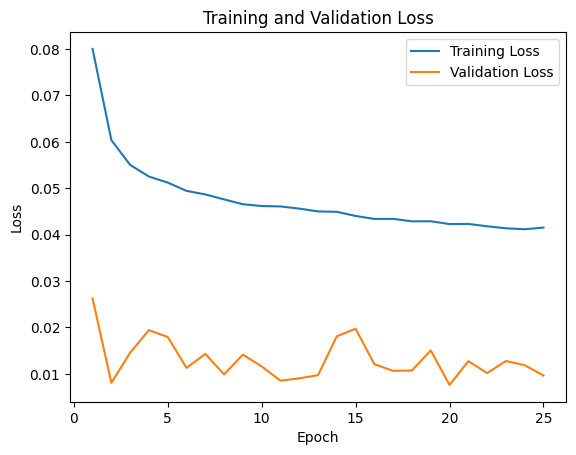

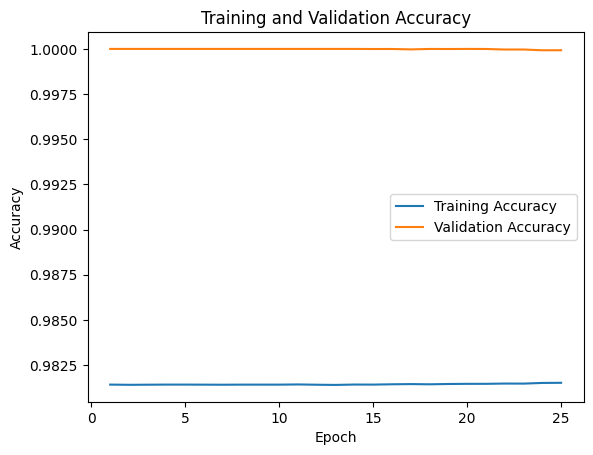

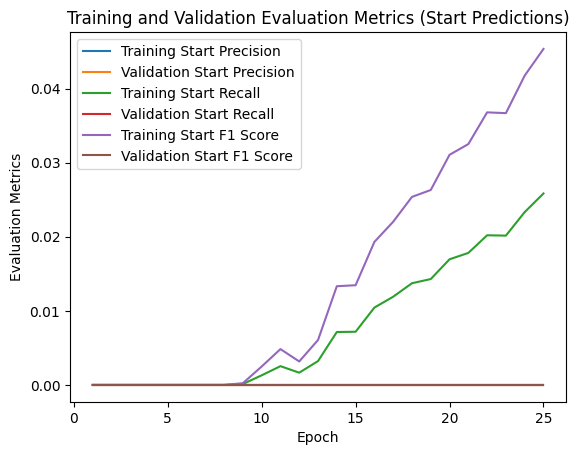

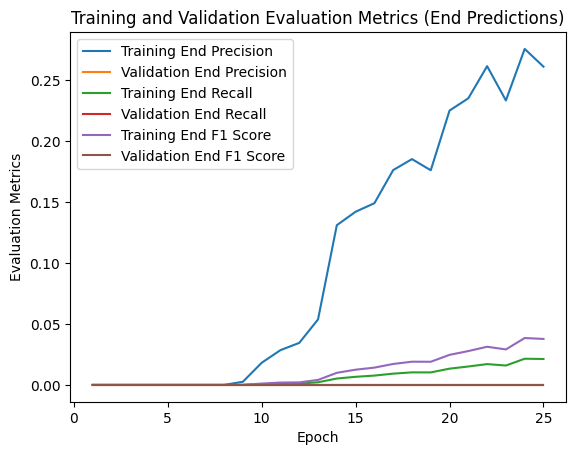

In [ ]:
# Set the hyperparameters
num_epochs = 25
learning_rate = 0.001

# Define the loss function and optimizer
loss_fn = nn.BCELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(lstm_model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device)

## 7. Test

- Load the 'testdata.csv' file provided.This file contains signal data with columns (Accelerometer and Gyroscope readings), excluding the Activity column.

In [ ]:
# Load and read the testing data
test_data_file = '/content/testdata.csv'
test_data = pd.read_csv(test_data_file)

# Display the first few rows of the DataFrame
test_data.head()

,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5
0,-0.833114,1.527048,9.118425,0.444920,-0.260176,-0.003165
1,-0.815806,1.547072,8.985757,0.455710,-0.386227,0.005471
2,-0.789316,1.577158,8.868717,0.417351,-0.415063,0.010528
3,-0.788688,1.586534,8.820272,0.346842,-0.376392,0.001030
4,-0.753974,1.617062,8.872701,0.247663,-0.293129,-0.025673


- Pre-processing: Normalising the test data using the statistics (such as mean and standard deviation) calculated from the original data. This ensures consistency and avoids data leakage, as the test data should be treated as unseen data during the modeling process.


In [ ]:
# Remove leading spaces from column names
test_data.columns = signal_data.columns.str.strip()

# Extract test accelerometer and gyroscope data
test_accelerometer_data = test_data[['AccelX_5', 'AccelY_5', 'AccelZ_5']].values
test_gyroscope_data = test_data[['GyroX_5', 'GyroY_5', 'GyroZ_5']].values

# Extract mean and standard deviation from original accelerometer and gyroscope normalized data
accelerometer_mean = signal_data[['AccelX_5', 'AccelY_5', 'AccelZ_5']].mean(axis=0)
accelerometer_std = signal_data[['AccelX_5', 'AccelY_5', 'AccelZ_5']].std(axis=0)
gyroscope_mean = signal_data[['GyroX_5', 'GyroY_5', 'GyroZ_5']].mean(axis=0)
gyroscope_std = signal_data[['GyroX_5', 'GyroY_5', 'GyroZ_5']].std(axis=0)

# Expand dimensions of mean and standard deviation arrays to match the shape of test accelerometer and gyroscope data
expanded_mean = np.expand_dims(accelerometer_mean, axis=0)
expanded_std = np.expand_dims(accelerometer_std, axis=0)
expanded_mean = np.expand_dims(gyroscope_mean, axis=0)
expanded_std = np.expand_dims(gyroscope_std, axis=0)

# Normalize test accelerometer and gyroscope data using mean and standard deviation of the original normalized data
normalized_test_accelerometer_data = (test_accelerometer_data - expanded_mean) / expanded_std
normalized_test_gyroscope_data = (test_gyroscope_data - expanded_mean) / expanded_std

# Replace the original accelerometer and gyroscope data with the normalized data
test_data[['AccelX_5', 'AccelY_5', 'AccelZ_5']] = normalized_test_accelerometer_data
test_data[['GyroX_5', 'GyroY_5', 'GyroZ_5']] = normalized_test_gyroscope_data

In [ ]:
# convert the test data to tensors
test_signals = torch.tensor(test_data.values, dtype=torch.float32)

# create the dataset and data loader
test_loader = DataLoader(test_signals, batch_size=batch_size, shuffle=False)

- Making predictions on the normalised test data.

In [ ]:
# Select the model and set it to evaluation mode
model = lstm_model
model.eval()

# Initialize empty lists to store the predictions
test_predictions = []

# Disable gradient calculation since you're only evaluating the model
with torch.no_grad():
    for signals in test_loader:
        signals = signals.to(device)  # Move signals to the device (e.g., GPU)

        # Make predictions using the model
        predictions = lstm_model(signals)

        # Append the predictions to the list
        test_predictions.append(predictions.cpu().numpy())  # Move predictions to CPU and convert to NumPy array

# Concatenate the predictions into a single NumPy array
test_predictions = np.concatenate(test_predictions)

print("Length of test predictions:", test_predictions.shape)

Length of test predictions: (102091, 2)


## 8. Result

- Generate the output file in the expected format of [index, start, end].

In [ ]:
def generate_output_file(output_file, test_predictions):
    # Extract the probabilities for the start and end of a step from the test predictions
    start_probabilities = test_predictions[:, 0]
    end_probabilities = test_predictions[:, 1]

    # Create a list of strings in the desired format: 'time_point,start_probability,end_probability'
    output_lines = ['index ,start ,end']
    for index, start, end in zip(range(len(start_probabilities)), start_probabilities, end_probabilities):
        line = f"{index},{start},{end}"
        output_lines.append(line)

    # Write the lines to the output file
    with open(output_file, 'w') as f:
        f.write('\n'.join(output_lines))

    print(f"Output file '{output_file}' generated successfully.")

In [ ]:
# output file path
output_file = 'outputB2.csv'

# generate output file
generate_output_file(output_file, test_predictions)

Output file 'outputB2.csv' generated successfully.
